In [246]:
#%pip install statsmodels
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import statsmodels.api as sm
from cointegration_functions import *

#stocks = pd.read_csv("C:/Users/adamt/OneDrive/Desktop/Jakub/masterThesis/stocks.csv",index_col = 0)

stocks = pd.read_csv("C:/Users/adamt/OneDrive - Wirtschaftsuniversität Wien - IT-SERVICES/Desktop/masterThesis/stocks.csv", index_col = 0)
#portfolio = pd.read_csv("C:/Users/adamt/OneDrive - Wirtschaftsuniversität Wien - IT-SERVICES/Desktop/masterThesis/test_files/select_cointegrated_pairs_test_result.csv",index_col = 0)

a,b = 200,700
stocks_norm = normalize(stocks[a:a+b+100])
stocks_formation = stocks_norm[a:a+b]
stocks_trading = stocks_norm[a+b+1:a+b+100]
pairs = calculate_and_sort_ssd(stocks_formation)
portfolio = select_cointegrated_pairs(stocks_formation,pairs)


def estimate_model(stocks_formation, portfolio):
    """
    Parameters: should be portfolio and stocks formation, 
    Y observed is defined as logx1 - logx2.
    Takes formation period spread (= observed y) and learns the parameters of the state-observation model (A,B,C,D) using EM algorithm.
    Estimates the model for each pair of the trading portfolio in the formation period.
    """
    portfolio_models = pd.DataFrame(columns=["A", "B", "C", "D"])

    for pair in portfolio.index:
        
        stock1, stock2 = pair.split("_")
        print("processing pair ", stock1, "and", stock2)
    
        # Spread= logP2 - logP1
        y_obs = np.log(stocks_formation[stock1]/stocks_formation[stock2])

        # Define the Kalman Filter
        kf = KalmanFilter(
            n_dim_obs=1, 
            n_dim_state=1, 
            em_vars=['transition_matrices', 'transition_offsets', 
                    'transition_covariance', 'observation_covariance']
        )

        print("estimating model....")

        # Estimate Parameters Using EM
        kf = kf.em(y_obs, n_iter=20)

        # Extract Learned Parameters
        A_est = kf.transition_offsets       # Estimated A
        B_est = kf.transition_matrices      # Estimated B
        C_est = np.sqrt(kf.transition_covariance)  # Estimated C (since Q = C^2)
        D_est = np.sqrt(kf.observation_covariance)  # Estimated D (since R = D^2)


        portfolio_models.loc[pair, "A"] = A_est.item()
        portfolio_models.loc[pair, "B"] = B_est.item()
        portfolio_models.loc[pair, "C"] = C_est.item()
        portfolio_models.loc[pair, "D"] = D_est.item()
        print("params of the spread for :", pair, "are ", A_est.item(), B_est.item(), C_est.item(), D_est.item())
      
        
    return portfolio_models


portfolio_models = estimate_model(stocks_formation=stocks_formation,portfolio=portfolio)

params of the spread for : ACN_BDX are  0.00029237650998427915 0.969175739603726 0.009575652169878367 0.00590462621316697
processing pair  AVB and JNPR
estimating model....
params of the spread for : AVB_JNPR are  0.00044921092540530964 0.9709207055263027 0.013813981631977343 0.00830536553598016


In [261]:
def trade_portfolio_kalman(portfolio_models, stocks_trading):
    """ 
    This performs the recursive kalman filter based on the parameterss A,B,C,D state-observation model estimated before.
    Takes the trading period stocks and performs the trading algorithm 
    """
    result_df = pd.DataFrame(index = stocks_trading.index)
    x_est_df = pd.DataFrame(index = stocks_trading.index)
    R_est_df = pd.DataFrame(index = stocks_trading.index)
    y_obs_df = pd.DataFrame(index = stocks_trading.index)
    
    n_diverged = 0
    trade_counts = {}

    # Process each pair
    for pair in portfolio_models.index:
        entered_trade = False
        stock1, stock2 = pair.split("_")

        print("proccesing pair: \n",  pair, "\n", 100*"-")
        A,B,C,D = portfolio_models.loc[pair]
       

        # spread for a given pair
        y_obs = np.log(stocks_trading[stock1]/stocks_trading[stock2])
       
        # x0 = y0 
        x_est = [y_obs.iloc[0]]  
        R_est = [D**2]
        K_hist  = [(B**2) * R_est[-1] + C**2  / ((B**2) * R_est[-1] + C**2 + D**2)]

        print("Params A,B,C,D are", A,B,C,D)
        
        pair_result = {}
        spread_t = 0
        pair_result[y_obs.index[0]] = 0.0
        
        print("Current observed spread is: ",  y_obs.iloc[0], "and Current filtered spread is", x_est[0])
        
        # Direction variable 1 long -1 short 
        direction = 0
        n_trades = 0 
        # proces spread each day for this pair 
        for i in range(1, len(y_obs.index)):
            
            date = stocks_trading.index[i]

            # y observed
            observed_y = y_obs.iloc[i] 

            # Kalman Filter recursion
            x = A + B * x_est[-1]
            R = (B**2) * R_est[-1] + C**2
            K = R / (R + D**2)
            x_hat = x + K * (observed_y - x)
            R_hat = R - K*R  #(D**2) * K
            
            x_est.append(x_hat)
            R_est.append(R_hat)
            K_hist.append(K)

            print(40*"-", "\nprocessing date", date)
            print("Current observed spread is: ",  y_obs.iloc[i], "and Current filtered spread is", x_est[i])
            # trade logic here, we compare prediction and signal 
            threshold = np.sqrt(R_hat) * 0.1 # threshold to enter the trade
            
            if observed_y > x_hat + threshold and not entered_trade:
                #observed spread is too large, enter trade 
                print("Observed spread ", observed_y ," is too big, short trade entered...")
                spread_t = observed_y
                direction = -1
                n_trades += 1
                entered_trade = True
            
            elif observed_y < x_hat - threshold and not entered_trade:
                # observed spread is too small, enter trade 
                print("Observed spread is too small, long trade entered...")
                spread_t = observed_y
                direction = +1
                n_trades += 1
                entered_trade = True

            # if the spread at time t was higher and 
            # current spread returns to the lower threshold, exit and save delta_spread = spread_t+n - spread_t
            if direction == -1 and observed_y < x_hat and entered_trade:
                print("Short trade was exited...return is :", abs(observed_y - spread_t))    
                entered_trade = False   # exit trade
                delta_spread = abs(observed_y - spread_t) # return = delta spread
            elif direction == +1 and observed_y > x_hat and entered_trade:
                print("Long trade was exited...return is :", abs(observed_y - spread_t))    
                entered_trade = False   # exit trade
                delta_spread = abs(observed_y - spread_t) # return = delta spread
            else: 
                # if trade is not entered or spread of the entered trade did not return to 0
                delta_spread = 0.0 

            #last day of trading
            if i == len(y_obs.index) - 1:
                date = stocks_trading.index[i]
                print("\n LAST DAY OF THE TRADING....", date)
                print("Last observed spread is:", observed_y, "and last filtered spread is:", x_est[i])

                if entered_trade:
                    spread_diff = observed_y - spread_t
                    print("Brute force close - observed vs. entry:", observed_y, spread_t)

                    # Determine profit/loss based on trade direction
                    if direction == 1:  # long
                        delta_spread = spread_diff
                    elif direction == -1:  # short
                        delta_spread = -spread_diff

                    print("Final delta_spread:", delta_spread)

                    # Convert to absolute profit/loss value
                    delta_spread = abs(delta_spread) if delta_spread >= 0 else -abs(delta_spread)
                    
                    if delta_spread < 0:
                        n_diverged += 1

            # Save the delta spread
            pair_result[date] = delta_spread
            trade_counts[pair] = n_trades
            
        # append to result df 
        result_df[pair] = pair_result
        x_est_df[pair] = x_est
        R_est_df[pair] = R_est
        y_obs_df[pair] = y_obs

    return x_est_df, y_obs_df, R_est_df, result_df, trade_counts

a,b = 200,700
stocks_formation = stocks[a:a+b]
stocks_trading = stocks[a+b+1:a+b+100]

# Call your function to get the two arrays
x_est, y_obs, R_est, result, trade_counts  = trade_portfolio_kalman(portfolio_models, stocks_trading=stocks_trading)

proccesing pair: 
 NWS_NWSA 
 ----------------------------------------------------------------------------------------------------
Params A,B,C,D are -0.010684843002706884 0.3809639566681229 0.005386206294951631 0.004013265175880031
Current observed spread is:  0.02696476715172704 and Current filtered spread is 0.02696476715172704
---------------------------------------- 
processing date 2018-10-08
Current observed spread is:  0.023976605096619256 and Current filtered spread is 0.015699009243511662
Observed spread  0.023976605096619256  is too big, short trade entered...
---------------------------------------- 
processing date 2018-10-09
Current observed spread is:  0.019346259624714188 and Current filtered spread is 0.01104476277095113
---------------------------------------- 
processing date 2018-10-10
Current observed spread is:  0.03105331527220718 and Current filtered spread is 0.0180951051369374
---------------------------------------- 
processing date 2018-10-11
Current observe

In [262]:
# return from trading KO_PEP
print(result.apply(sum))
print(result.sum(axis=1).sum())
trade_counts

NWS_NWSA     0.000978
ETR_WEC      0.035211
L_USB        0.399153
AEP_ES      -0.012740
DUK_SRE      0.236730
LNT_NI       0.034235
DIS_JNPR    -0.005123
AEP_CPT      0.210018
CMS_DTE     -0.006809
AEE_AWK      0.000202
EXPD_NDAQ    0.038670
BXP_REG      0.119690
BRK-B_ICE    0.138414
D_HSY        0.009183
FRT_PSA      0.225906
HBAN_TFC    -0.105788
HBAN_NTRS    0.063959
GOOG_HD      0.037650
ACN_BDX      0.152512
AVB_JNPR    -0.139212
dtype: float64
1.4328391857857452


{'NWS_NWSA': 1,
 'ETR_WEC': 2,
 'L_USB': 24,
 'AEP_ES': 1,
 'DUK_SRE': 11,
 'LNT_NI': 1,
 'DIS_JNPR': 2,
 'AEP_CPT': 23,
 'CMS_DTE': 1,
 'AEE_AWK': 6,
 'EXPD_NDAQ': 1,
 'BXP_REG': 6,
 'BRK-B_ICE': 3,
 'D_HSY': 3,
 'FRT_PSA': 12,
 'HBAN_TFC': 1,
 'HBAN_NTRS': 1,
 'GOOG_HD': 1,
 'ACN_BDX': 9,
 'AVB_JNPR': 1}

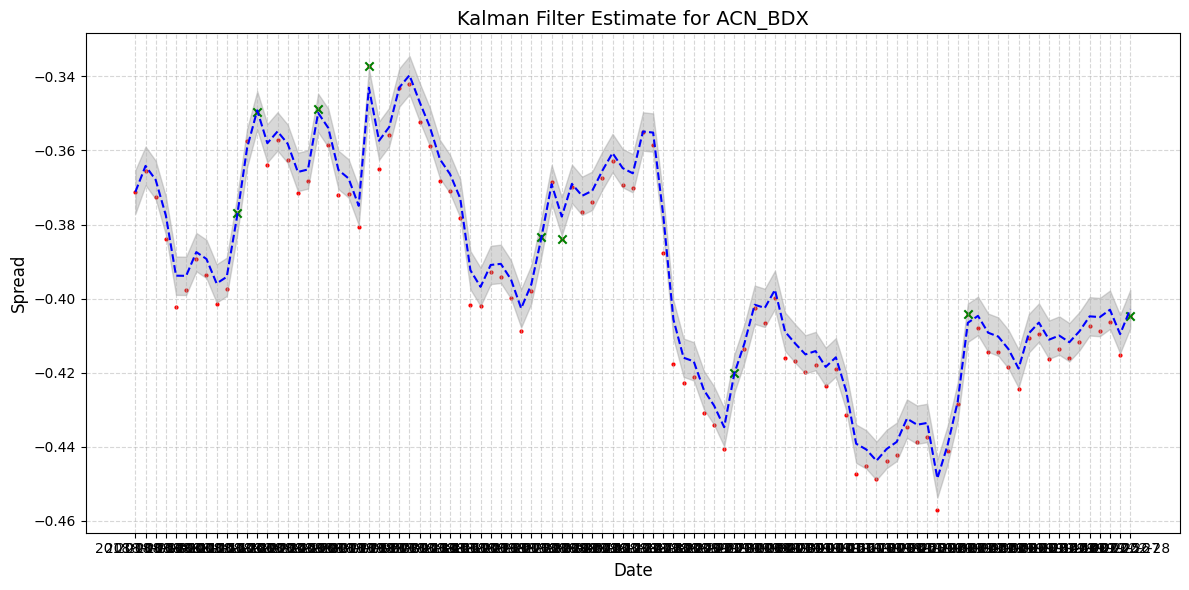

In [ ]:

def plot_kalman(pair, x_est, y_obs, R_est, result):
    """
    Plot Kalman Filter spread estimate with ±1σ bands and residual markers.
    
    Parameters:
        pair (str): Name of the spread column to visualize, e.g., "AEP_PCG"
        x_est (DataFrame): Kalman filtered estimate of the spread
        y_obs (DataFrame): Observed spread values
        R_est (DataFrame): Estimated variance 
    """
    # Compute upper and lower 1σ bands
    upper_band = x_est[pair] + np.sqrt(R_est[pair].values)
    lower_band = x_est[pair] - np.sqrt(R_est[pair].values)
    # Compute residuals
    returns = result[pair]
    # Indices where residuals are non-zero
    nonzero_mask = returns != 0
    pos_mask = (returns > 0) & nonzero_mask
    neg_mask = (returns < 0) & nonzero_mask
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.scatter(y_obs[pair].index, y_obs[pair].values, label='Observed Spread', color='red', s=4)
    plt.plot(x_est[pair].index, x_est[pair].values, label='Filtered Spread (Kalman)', color='blue', linestyle='--')
    plt.fill_between(x_est[pair].index, lower_band, upper_band, color='gray', alpha=0.3, label='±1σ Band')
    # Plot residual markers
    plt.scatter(returns.index[pos_mask], y_obs[pair][pos_mask], marker='x', color='green', label='Return')
    plt.scatter(returns.index[neg_mask], y_obs[pair][neg_mask], marker='x', color='red', label='Loss')
    # Formatting
    plt.title(f'Kalman Filter Estimate for {pair}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Spread', fontsize=12)
    #plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_kalman("ACN_BDX", x_est, y_obs, R_est,result)

In [ ]:
result

Date
2017-12-19    0.000000
2017-12-20    0.000000
2017-12-21    0.000000
2017-12-22    0.000000
2017-12-26    0.000000
                ...   
2018-05-07    0.000000
2018-05-08    0.000000
2018-05-09    0.000000
2018-05-10    0.000000
2018-05-11   -0.141647
Name: MCD_PEP, Length: 99, dtype: float64